In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import src
from src.reload import deep_reload

In [2]:
'''
Making a random entities graph
'''
deep_reload(src)

n = 100
k = 2

rng = np.random.default_rng(26893751)

kwargs = {
    'rng': rng,
    'label': 'place',
    'x': lambda n: rng.uniform(0, 1e6, size = (n, )),
    'y': lambda n: rng.uniform(0, 1e6, size = (n, )),
    'node_functions': {
        'population': lambda n: 10 ** rng.uniform(3, 7),
    },
    'edge_functions': {
        'speed': lambda e: rng.uniform(45, 75) * 1609 / 3600,
        'time': lambda e: e['distance'] / e['speed'],
    },
    'nx': {
        # 'directed': True,
    },
}

entities = src.rng.random_connected_graph(n, k, **kwargs)
entities = nx.DiGraph(entities)

'''
Adding Station locations
'''

m = 100

kwargs = {
    'rng': rng,
    'label': 'station',
    'range': (.25, .75),
    'node_functions': {
        'population': lambda n: 0,
    },
    'edge_functions': {
        'speed': lambda e: rng.uniform(45, 75) * 1609 / 3600,
        'time': lambda e: e['distance'] / e['speed'],
    },
}

entities = src.rng.random_intermediate_nodes(entities, m, **kwargs)

places = [k for k in entities.nodes if 'place' in k]
stations = [k for k in entities.nodes if 'station' in k]

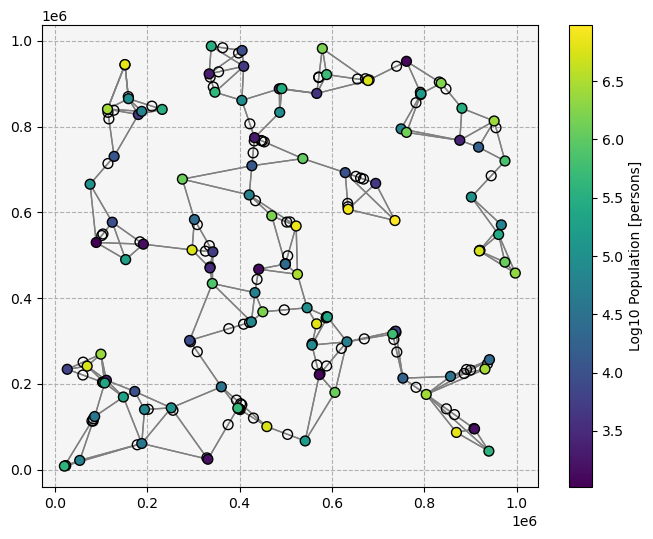

In [3]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in entities._node.items():

    node['plot'] = np.log10(node['population'])

cmap = src.figures.Colormap('viridis')

nodes = {
    'field': 'plot',
    'cmap': cmap,
    'plot': {
        's': 50,
        'ec': 'k',
        'zorder': 3,
    },
    'colorbar': {
        'label': 'Log10 Population [persons]',
    },
}

edges = {
    'plot': {
        'lw': 1,
        'color': 'gray',
    },
}

kw = {
    'edges': edges,
    'nodes': nodes,
}

plots = src.figures.plot_graph(entities, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [4]:
'''
Creating the All-Pairs Graph (APG)
'''
deep_reload(src)

fields = ['time', 'distance']

graph = src.routing.shortest_path_graph(entities, fields)

In [5]:
'''
Creating the Gravity Model
'''
deep_reload(src)

values, bins = pkl.load(open('histogram.pkl', 'rb'))
friction = src.gravity.Friction(values, bins * 1e3)

kw = {
    'friction': friction,
}

gravity = src.gravity.Gravity(graph, **kw)

In [6]:
'''
Creating a Vehicle
'''
deep_reload(src)

vehicle = src.objects.Vehicle(capacity = 80 * 3.6e6)

'''
Adding Station objects
'''

seed = 26893751
rng = np.random.default_rng(seed)

queue = src.queue.Queue()

functions = {
    'size': lambda: rng.integers(4, 10),
    'reliability': lambda: .75,
}

kwargs = {
    'cutoff': 3600,
    'setup_time': 180,
}

for source in stations:

    node = graph._node[source]

    kwargs['node'] = node
    kwargs['edges'] = [e for e in graph._adj[source].values()]
    
    node['object'] = src.objects.random_station(rng, functions, **kwargs)
    node['object'].update_graph(vehicle)

kwargs = {}

for source in places:

    node = graph._node[source]

    kwargs['node'] = node
    kwargs['edges'] = [e for e in graph._adj[source].values()]

    node['object'] = src.objects.Place(**kwargs)
    node['object'].update_graph(vehicle)

In [7]:
'''
Re-setting the Station objects
'''
deep_reload(src)

graph = src.objects.reset_stations(graph, vehicle)

In [8]:
'''
Saturating the graph
'''
deep_reload(src)

kw = {
    'terminals': places,
    'pivots': stations,
    'field': 'total_time',
}

ratios = gravity.to_array('ratios')

saturation = src.saturation.Saturation(graph, ratios, queue, **kw)

results = saturation.run()

 [----->      ] (58/100) 58.00%, 201.84 it/s, 0.29 s elapsed, 0.20 s remaining

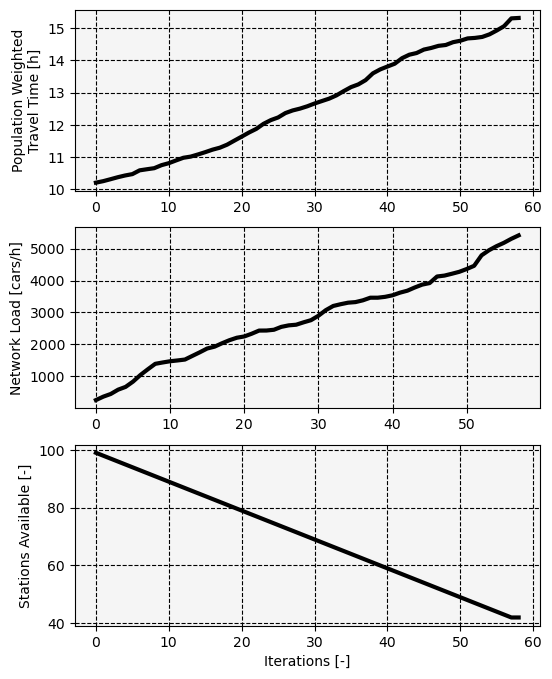

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (6, 8))

line_kw = {
    'lw': 3,
    'color': 'k',
}

y = results['network']['performance']
x = list(range(len(y)))

ax[0].plot(x, y / 3600, **line_kw)
ax[0].set_ylabel('Population Weighted\nTravel Time [h]')

y = results['network']['load']
x = list(range(len(y)))

ax[1].plot(x, y * 3600, **line_kw)
ax[1].set_ylabel('Network Load [cars/h]')

y = results['network']['availability']
x = list(range(len(y)))

ax[2].plot(x, y, **line_kw)
ax[2].set_xlabel('Iterations [-]')
ax[2].set_ylabel('Stations Available [-]')

kw = {
    'facecolor': 'whitesmoke',
}

_ = [ax.set(**kw) for ax in ax]

kw = {
    'color': 'k',
    'ls': '--',
}

_ = [ax.grid(**kw) for ax in ax]

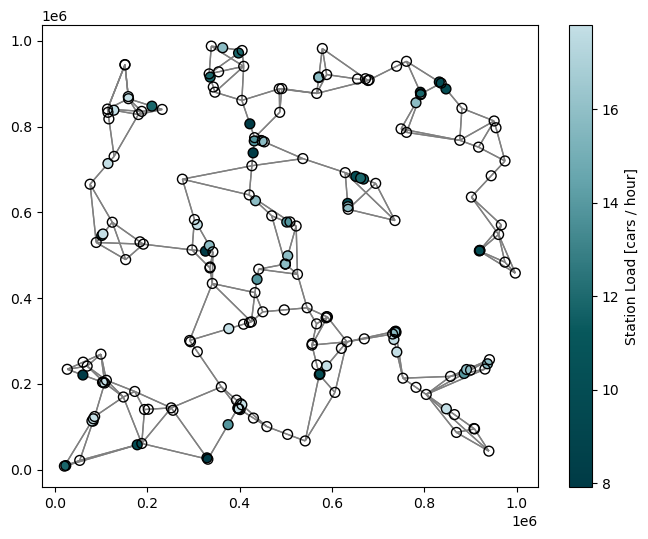

In [10]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

for source, node in graph._node.items():

    load = results['node']['load'][-1][source] * 3600

    node['plot'] = np.nan if load ==0 else load

cmap = src.figures.Colormap('ocean')

nodes = {
    'field': 'plot',
    'cmap': cmap,
    'plot': {
        's': 50,
        'ec': 'k',
        'zorder': 3,
    },
    'colorbar': {
        'label': 'Station Load [cars / hour]',
    },
}

edges = {
    'plot': {
        'lw': 1,
        'color': 'gray',
    },
}

kw = {
    'edges': edges,
}

plots = src.figures.plot_graph(entities, ax = ax, **kw)

kw = {
    'nodes': nodes,
}

plots = src.figures.plot_graph(graph, ax = ax, **kw)